In [13]:
#data manipulation

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor



In [14]:
#Timer function
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    else:
        duration = (datetime.now() - start_time).total_seconds()
        print("Took %i seconds" % duration)

In [15]:
os.getcwd()
df = pd.read_csv('../Data/train.csv')
dt = pd.read_csv('../Data/test.csv')

In [3]:
df.head(3)

,Index,Market,Day,Stock,x0,x1,x2,x3A,x3B,x3C,x3D,x3E,x4,x5,x6,y,Weight
0,0,1,1,363,0.002696,0.530040,0.400810,1.300048e-06,4.639533e-06,1.073594e-05,0.000022,0.000044,0.002212,6.214737e-07,200.000000,-0.000196,1.533780
1,1,1,1,1223,0.081093,1.366218,1.325157,1.656861e-05,3.024668e-05,5.261872e-05,0.000042,0.000042,0.010932,3.414868e-05,300.000000,-0.003798,0.843604
2,2,1,1,1372,0.009561,0.464871,0.328008,6.500872e-08,2.323204e-07,5.182686e-07,0.000001,0.000002,0.000306,4.079460e-08,159.692076,-0.000003,29.824024


In [4]:
df.shape

(623817, 17)

In [15]:
c = df.columns
c

Index(['Index', 'Market', 'Day', 'Stock', 'x0', 'x1', 'x2', 'x3A', 'x3B',
       'x3C', 'x3D', 'x3E', 'x4', 'x5', 'x6', 'y', 'Weight'],
      dtype='object')

In [16]:
#get rid of NaN values
#find out which columns has null values
columns = df.columns
for i in range(len(df.columns)):
    index = df.index[df[columns[i]].isnull()]
    if index.shape[0]>0:
        print(df.columns[i],index.shape)
        df[columns[i]] = df[columns[i]].fillna(0)
columns2 = dt.columns
for i in range(len(dt.columns)):
    index2 = dt.index[dt[columns2[i]].isnull()]
    if index2.shape[0]>0:
        print(dt.columns[i],index2.shape)
        dt[columns2[i]] = dt[columns2[i]].fillna(0)

x1 (55,)
x2 (5,)
x1 (62,)
x2 (2,)


In [17]:
#training dataset and test dataset
x_train = df.drop(['Weight','y'],axis = 1)
x_weight = np.array(df.Weight)
y_train = df.y
x_test = dt

In [32]:
#regression modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

In [57]:
#KNN Regressor 25.6%
knn = KNeighborsRegressor()
knn.fit(x_train,y_train)
acc_knn = round(knn.score(x_train,y_train)*100,2)
acc_knn

25.6

In [56]:
#Random Forest 36.7%
rf = RandomForestRegressor()
rf.fit(x_train,y_train,sample_weight = x_weight)
acc_rf = round(rf.score(x_train,y_train,x_weight)*100,2)
acc_rf

34.48

In [224]:

#using random forest regressor, very low, around 10%
# kfold returns array indexes
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def run_kfold(model):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(x_train):
        fold += 1
        xfold_train, xfold_test = x_train.values[train_index], x_train.values[test_index]
        yfold_train, yfold_test = y_train.values[train_index], y_train.values[test_index]
        xfold_weight = x_weight[train_index]
        model.fit(xfold_train, yfold_train)
        #predictions = model.predict(xfold_test)
        accuracy = model.score(xfold_test, yfold_test)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(rf)

Fold 1 accuracy: 0.08160542313407126
Fold 2 accuracy: -0.04748002210001068
Fold 3 accuracy: -0.017682503865019905
Fold 4 accuracy: 0.009632548771566274
Fold 5 accuracy: 0.0150056421368846
Fold 6 accuracy: 0.12184604840497038
Fold 7 accuracy: 0.14461839290483514
Fold 8 accuracy: 0.11090489483175149


KeyboardInterrupt: 

In [66]:
# gridsearchCV
# what parameters are there for random forest regressor?
# best fit parameter: max_depth = 6, min_weight_fraction_leaf = 0.001,
# n_estimators = 40, min_sample_split = 4
from sklearn.model_selection import GridSearchCV
def RFTuneParameter(x_train, y_train, weight):
    rf = RandomForestRegressor(max_depth = 6, min_weight_fraction_leaf = 0.001)
    param_grid = { 
            "min_samples_split"        : [3, 4],
            "n_estimators"             : [30, 40]     
            }
    rfcv = GridSearchCV(rf,param_grid)
    if type(weight)==str:
        rfcv.fit(x_train,y_train)
    else:
        rfcv.fit(x_train,y_train,weight)
    return rfcv.best_score_, rfcv.best_params_
RFTuneParameter(x_train,y_train,x_weight)

(0.1222598308639286, {'min_samples_split': 4, 'n_estimators': 40})

In [78]:
# predict with best fit parameters
rf = RandomForestRegressor(max_depth = 6, min_weight_fraction_leaf = 0.001, n_estimators = 40, min_samples_split = 4)
rf.fit(x_train, y_train, x_weight)
yp = pd.Series(rf.predict(x_test)).rename('y')
yp.index.name = 'Index'
yp.head()

Index
0    0.000008
1    0.000008
2    0.000008
3    0.000008
4    0.000008
Name: y, dtype: float64

In [81]:
yp.to_csv('RandomForestRegressor_model.csv', header=True)

([<matplotlib.axis.XTick at 0x1a168b8160>,
 <a list of 15 Text xticklabel objects>)

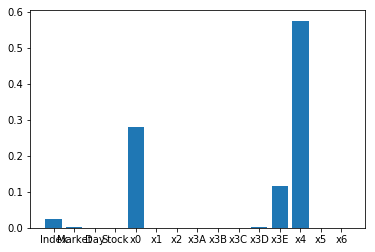

In [80]:
#get feature importance from random forest regression
importance = rf.feature_importances_
plt.bar(range(x_train.shape[1]),importance)
plt.xticks(range(x_train.shape[1]),x_train.columns)

In [47]:
model = XGBRegressor()
model.fit(x_train, y_train)
# xgb.DMatrix?
# print(df.shape)
# #dtrain.size()
# dtest.num_row()
# dtrain.num_col()
# print(dtrain.get_label())
# dtest.get_label()
# # specify parameters via map

# bst = xgb.train(param, dtrain, num_round)
# # # make prediction
# # ntree_limit must not be 0
# preds = bst.predict(dtest, ntree_limit=num_round)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
# predict result with trained model
yp = pd.Series(model.predict(x_test)).rename('y')
yp.index.name = 'Index'

In [50]:
# save predicted data to csv
yp.to_csv('XGBoostRegressor_model.csv', header=True)

In [70]:
# gridsearchCV
# tune parameters for XGBoost
# best fit parameter: learning_rate = 0.1, max_depth = 4, min_child_weight = 5
from sklearn.model_selection import GridSearchCV
def XGBTuneParameter(x_train, y_train, weight):
    xgb_model = XGBRegressor()
    param_grid = { 
            "max_depth"                    : [3, 4],
            "min_child_weight"             : [5, 10],
            "learning_rate"                : [0.1, 0.2]
            }
    xgbcv = GridSearchCV(xgb_model,param_grid)
    if type(weight)==str:
        xgbcv.fit(x_train,y_train)
    else:
        xgbcv.fit(x_train,y_train,weight)
    return xgbcv.best_score_, xgbcv.best_params_
XGBTuneParameter(x_train,y_train,x_weight)

(0.1407272804994852,
 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5})

In [88]:
#XGB Regressor with tuned parameter 0.39
XGBmodel = XGBRegressor(learning_rate = 0.1, max_depth = 4, min_child_weight = 4, n_estimators = 120)
XGBmodel.fit(x_train, y_train, x_weight)
print(XGBmodel.score(x_train, y_train, x_weight))

0.39353081542661794


In [85]:
# predict result with trained model
yp = pd.Series(XGBmodel.predict(x_test)).rename('y')
yp.index.name = 'Index'

In [86]:
# save predicted data to csv
yp.to_csv('XGBRegressor_tuned2.csv', header=True)

In [132]:
#Split training data set into train and test
train_df, test_df = train_test_split(df, test_size = 0.5)

In [133]:
#training dataset and test dataset
x_split_train = train_df.drop(['Weight','y'],axis = 1)
x_split_train_weight = np.array(train_df.Weight)
y_split_train = train_df.y

x_split_test = test_df.drop(['Weight','y'],axis = 1)
y_split_test = test_df.y


In [151]:
# Evaulate how the model trains. Try to find the early stopping point once the model starts
# to overfit
eval_set = ([x_split_train,y_split_train],[x_split_test, y_split_test])
XGBmodel = XGBRegressor(learning_rate = 0.1, max_depth = 4, min_child_weight = 5, n_estimators = 1000)
XGBmodel.fit(x_split_train, y_split_train, sample_weight = x_split_train_weight, early_stopping_rounds = 10, eval_metric=["logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = XGBmodel.predict(x_split_test)
# evaluate predictions
accuracy = r2_score(y_split_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = XGBmodel.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)


[0]	validation_0-logloss:0.597855	validation_1-logloss:0.597855
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.519227	validation_1-logloss:0.519227
[2]	validation_0-logloss:0.453391	validation_1-logloss:0.453391
[3]	validation_0-logloss:0.397633	validation_1-logloss:0.397633
[4]	validation_0-logloss:0.349979	validation_1-logloss:0.349979
[5]	validation_0-logloss:0.308951	validation_1-logloss:0.308951
[6]	validation_0-logloss:0.273414	validation_1-logloss:0.273414
[7]	validation_0-logloss:0.242477	validation_1-logloss:0.242477
[8]	validation_0-logloss:0.21543	validation_1-logloss:0.21543
[9]	validation_0-logloss:0.191704	validation_1-logloss:0.191704
[10]	validation_0-logloss:0.170818	validation_1-logloss:0.170819
[11]	validation_0-logloss:0.152388	validation_1-logloss:0.152389
[12]	validation_0-logloss:0.136093	validation_1-logloss:0.136094
[1

[123]	validation_0-logloss:-0.001306	validation_1-logloss:-0.00119
[124]	validation_0-logloss:-0.001308	validation_1-logloss:-0.001192
[125]	validation_0-logloss:-0.001309	validation_1-logloss:-0.001193
[126]	validation_0-logloss:-0.001309	validation_1-logloss:-0.001193
[127]	validation_0-logloss:-0.001311	validation_1-logloss:-0.001196
[128]	validation_0-logloss:-0.001313	validation_1-logloss:-0.001196
[129]	validation_0-logloss:-0.001314	validation_1-logloss:-0.001195
[130]	validation_0-logloss:-0.001313	validation_1-logloss:-0.001196
[131]	validation_0-logloss:-0.001313	validation_1-logloss:-0.001197
[132]	validation_0-logloss:-0.001314	validation_1-logloss:-0.001197
[133]	validation_0-logloss:-0.001315	validation_1-logloss:-0.001195
[134]	validation_0-logloss:-0.001317	validation_1-logloss:-0.001195
[135]	validation_0-logloss:-0.001318	validation_1-logloss:-0.001195
[136]	validation_0-logloss:-0.001319	validation_1-logloss:-0.001196
[137]	validation_0-logloss:-0.001319	validation_1

In [197]:
XGBmodel.best_iteration

197

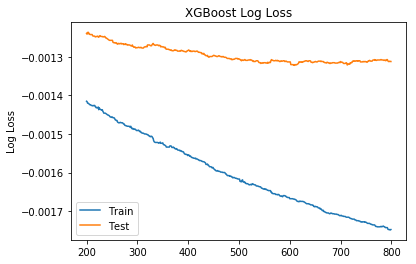

In [145]:
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis[200:800], results['validation_0']['logloss'][200:800], label='Train')
ax.plot(x_axis[200:800], results['validation_1']['logloss'][200:800], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


In [18]:
# Tune XGBoost hyperparameters
# (1) Set a low learning rate and find the best stopping point

#using random forest regressor, very low, around 10%
# kfold returns array indexes
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
#result set [accuracy_score, n_estimators]
result_set = []

def run_kfold(output_array):
    kf = KFold(n_splits=10)
    fold = 0
    for train_index, test_index in kf.split(x_train):
        fold += 1
        xfold_train, xfold_test = x_train.values[train_index], x_train.values[test_index]
        yfold_train, yfold_test = y_train.values[train_index], y_train.values[test_index]
        xfold_weight = x_weight[train_index]
        eval_set = ([xfold_train,yfold_train],[xfold_test, yfold_test])
        XGBmodel = XGBRegressor(learning_rate = 0.1, max_depth = 4, min_child_weight = 5, n_estimators = 1000)
        XGBmodel.fit(xfold_train, yfold_train, sample_weight = xfold_weight, early_stopping_rounds = 10, eval_metric=["logloss"], eval_set=eval_set, verbose=True)
        # make predictions for test data
        y_pred = XGBmodel.predict(xfold_test)
        # evaluate predictions
        accuracy = r2_score(yfold_test, y_pred)
        output_array.append([accuracy, XGBmodel.best_iteration])
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        print("Best iteration: %d" %XGBmodel.best_iteration)
     
run_kfold(result_set)

[0]	validation_0-logloss:0.597849	validation_1-logloss:0.597891
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.519216	validation_1-logloss:0.519298
[2]	validation_0-logloss:0.453375	validation_1-logloss:0.453494
[3]	validation_0-logloss:0.397612	validation_1-logloss:0.397765
[4]	validation_0-logloss:0.349955	validation_1-logloss:0.35014
[5]	validation_0-logloss:0.308923	validation_1-logloss:0.30914
[6]	validation_0-logloss:0.273382	validation_1-logloss:0.273629
[7]	validation_0-logloss:0.242442	validation_1-logloss:0.242718
[8]	validation_0-logloss:0.215392	validation_1-logloss:0.215697
[9]	validation_0-logloss:0.191662	validation_1-logloss:0.191997
[10]	validation_0-logloss:0.170777	validation_1-logloss:0.171141
[11]	validation_0-logloss:0.152347	validation_1-logloss:0.15274
[12]	validation_0-logloss:0.136043	validation_1-logloss:0.136462
[13

[123]	validation_0-logloss:-0.001449	validation_1-logloss:0.00041
[124]	validation_0-logloss:-0.001449	validation_1-logloss:0.000413
[125]	validation_0-logloss:-0.001453	validation_1-logloss:0.000407
[126]	validation_0-logloss:-0.001456	validation_1-logloss:0.000404
[127]	validation_0-logloss:-0.001457	validation_1-logloss:0.000404
[128]	validation_0-logloss:-0.001457	validation_1-logloss:0.000404
[129]	validation_0-logloss:-0.001457	validation_1-logloss:0.000403
[130]	validation_0-logloss:-0.001459	validation_1-logloss:0.000403
[131]	validation_0-logloss:-0.00146	validation_1-logloss:0.000401
[132]	validation_0-logloss:-0.001461	validation_1-logloss:0.000397
[133]	validation_0-logloss:-0.001461	validation_1-logloss:0.000401
[134]	validation_0-logloss:-0.001461	validation_1-logloss:0.000393
[135]	validation_0-logloss:-0.001462	validation_1-logloss:0.000393
[136]	validation_0-logloss:-0.001463	validation_1-logloss:0.000393
[137]	validation_0-logloss:-0.001463	validation_1-logloss:0.0003

[49]	validation_0-logloss:0.002913	validation_1-logloss:0.003664
[50]	validation_0-logloss:0.002633	validation_1-logloss:0.003396
[51]	validation_0-logloss:0.002365	validation_1-logloss:0.003157
[52]	validation_0-logloss:0.002128	validation_1-logloss:0.002951
[53]	validation_0-logloss:0.001912	validation_1-logloss:0.002725
[54]	validation_0-logloss:0.001722	validation_1-logloss:0.002538
[55]	validation_0-logloss:0.001536	validation_1-logloss:0.00236
[56]	validation_0-logloss:0.001368	validation_1-logloss:0.002167
[57]	validation_0-logloss:0.001202	validation_1-logloss:0.002012
[58]	validation_0-logloss:0.00106	validation_1-logloss:0.001883
[59]	validation_0-logloss:0.000916	validation_1-logloss:0.001734
[60]	validation_0-logloss:0.000785	validation_1-logloss:0.001567
[61]	validation_0-logloss:0.000661	validation_1-logloss:0.001397
[62]	validation_0-logloss:0.000544	validation_1-logloss:0.001258
[63]	validation_0-logloss:0.000437	validation_1-logloss:0.001137
[64]	validation_0-logloss:0

[56]	validation_0-logloss:0.001414	validation_1-logloss:0.001677
[57]	validation_0-logloss:0.001255	validation_1-logloss:0.001531
[58]	validation_0-logloss:0.001098	validation_1-logloss:0.001355
[59]	validation_0-logloss:0.000952	validation_1-logloss:0.001229
[60]	validation_0-logloss:0.000816	validation_1-logloss:0.001114
[61]	validation_0-logloss:0.000695	validation_1-logloss:0.000992
[62]	validation_0-logloss:0.00058	validation_1-logloss:0.000833
[63]	validation_0-logloss:0.000466	validation_1-logloss:0.000686
[64]	validation_0-logloss:0.000359	validation_1-logloss:0.000591
[65]	validation_0-logloss:0.000259	validation_1-logloss:0.000506
[66]	validation_0-logloss:0.000165	validation_1-logloss:0.000398
[67]	validation_0-logloss:7.4e-05	validation_1-logloss:0.000301
[68]	validation_0-logloss:-9e-06	validation_1-logloss:0.000204
[69]	validation_0-logloss:-9.9e-05	validation_1-logloss:0.000111
[70]	validation_0-logloss:-0.000184	validation_1-logloss:3.3e-05
[71]	validation_0-logloss:-0.

Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.519229	validation_1-logloss:0.519213
[2]	validation_0-logloss:0.453393	validation_1-logloss:0.453371
[3]	validation_0-logloss:0.397636	validation_1-logloss:0.397606
[4]	validation_0-logloss:0.349982	validation_1-logloss:0.349947
[5]	validation_0-logloss:0.308955	validation_1-logloss:0.308914
[6]	validation_0-logloss:0.273419	validation_1-logloss:0.273371
[7]	validation_0-logloss:0.242482	validation_1-logloss:0.242429
[8]	validation_0-logloss:0.215441	validation_1-logloss:0.21538
[9]	validation_0-logloss:0.191717	validation_1-logloss:0.191647
[10]	validation_0-logloss:0.170838	validation_1-logloss:0.170759
[11]	validation_0-logloss:0.152411	validation_1-logloss:0.152326
[12]	validation_0-logloss:0.136114	validation_1-logloss:0.136021
[13]	validation_0-logloss:0.121673	validation_1-logloss:0.121573


[20]	validation_0-logloss:0.056549	validation_1-logloss:0.056366
[21]	validation_0-logloss:0.050789	validation_1-logloss:0.0506
[22]	validation_0-logloss:0.045635	validation_1-logloss:0.045439
[23]	validation_0-logloss:0.041016	validation_1-logloss:0.040813
[24]	validation_0-logloss:0.03688	validation_1-logloss:0.036671
[25]	validation_0-logloss:0.033172	validation_1-logloss:0.032956
[26]	validation_0-logloss:0.029849	validation_1-logloss:0.029627
[27]	validation_0-logloss:0.026869	validation_1-logloss:0.026641
[28]	validation_0-logloss:0.024192	validation_1-logloss:0.023959
[29]	validation_0-logloss:0.021793	validation_1-logloss:0.021554
[30]	validation_0-logloss:0.019639	validation_1-logloss:0.019395
[31]	validation_0-logloss:0.017705	validation_1-logloss:0.017456
[32]	validation_0-logloss:0.015969	validation_1-logloss:0.015715
[33]	validation_0-logloss:0.014409	validation_1-logloss:0.01415
[34]	validation_0-logloss:0.013007	validation_1-logloss:0.012743
[35]	validation_0-logloss:0.0

[144]	validation_0-logloss:-0.00139	validation_1-logloss:-0.00061
[145]	validation_0-logloss:-0.00139	validation_1-logloss:-0.00061
[146]	validation_0-logloss:-0.00139	validation_1-logloss:-0.000608
[147]	validation_0-logloss:-0.001392	validation_1-logloss:-0.00061
[148]	validation_0-logloss:-0.001394	validation_1-logloss:-0.000612
[149]	validation_0-logloss:-0.001394	validation_1-logloss:-0.000612
[150]	validation_0-logloss:-0.001394	validation_1-logloss:-0.000611
[151]	validation_0-logloss:-0.001395	validation_1-logloss:-0.000611
[152]	validation_0-logloss:-0.001396	validation_1-logloss:-0.000612
[153]	validation_0-logloss:-0.001396	validation_1-logloss:-0.000612
[154]	validation_0-logloss:-0.001396	validation_1-logloss:-0.000612
[155]	validation_0-logloss:-0.001401	validation_1-logloss:-0.00061
[156]	validation_0-logloss:-0.001402	validation_1-logloss:-0.00061
[157]	validation_0-logloss:-0.001405	validation_1-logloss:-0.000611
[158]	validation_0-logloss:-0.001405	validation_1-loglos

[106]	validation_0-logloss:-0.001299	validation_1-logloss:-0.000953
[107]	validation_0-logloss:-0.001299	validation_1-logloss:-0.000958
[108]	validation_0-logloss:-0.001301	validation_1-logloss:-0.000962
[109]	validation_0-logloss:-0.001303	validation_1-logloss:-0.000963
[110]	validation_0-logloss:-0.001303	validation_1-logloss:-0.000964
[111]	validation_0-logloss:-0.001304	validation_1-logloss:-0.000961
[112]	validation_0-logloss:-0.001305	validation_1-logloss:-0.00096
[113]	validation_0-logloss:-0.001306	validation_1-logloss:-0.00096
[114]	validation_0-logloss:-0.001306	validation_1-logloss:-0.000957
[115]	validation_0-logloss:-0.001308	validation_1-logloss:-0.000957
[116]	validation_0-logloss:-0.001307	validation_1-logloss:-0.000957
[117]	validation_0-logloss:-0.001313	validation_1-logloss:-0.000956
[118]	validation_0-logloss:-0.001318	validation_1-logloss:-0.000955
[119]	validation_0-logloss:-0.001318	validation_1-logloss:-0.000954
[120]	validation_0-logloss:-0.001319	validation_1-

[106]	validation_0-logloss:-0.001234	validation_1-logloss:-0.001532
[107]	validation_0-logloss:-0.001235	validation_1-logloss:-0.001532
[108]	validation_0-logloss:-0.001236	validation_1-logloss:-0.001534
[109]	validation_0-logloss:-0.001238	validation_1-logloss:-0.001535
[110]	validation_0-logloss:-0.001239	validation_1-logloss:-0.001537
[111]	validation_0-logloss:-0.001241	validation_1-logloss:-0.001537
[112]	validation_0-logloss:-0.001241	validation_1-logloss:-0.001538
[113]	validation_0-logloss:-0.001242	validation_1-logloss:-0.00154
[114]	validation_0-logloss:-0.001242	validation_1-logloss:-0.001541
[115]	validation_0-logloss:-0.001246	validation_1-logloss:-0.001541
[116]	validation_0-logloss:-0.001247	validation_1-logloss:-0.001541
[117]	validation_0-logloss:-0.001247	validation_1-logloss:-0.001542
[118]	validation_0-logloss:-0.001249	validation_1-logloss:-0.001543
[119]	validation_0-logloss:-0.001254	validation_1-logloss:-0.001543
[120]	validation_0-logloss:-0.001254	validation_1

KeyboardInterrupt: 

In [185]:
# check that datasets are still correct
print(x_train.shape)
print(x_weight.shape)
print(y_train.shape)
print(x_test.shape)

(623817, 15)
(623817,)
(623817,)
(640430, 15)


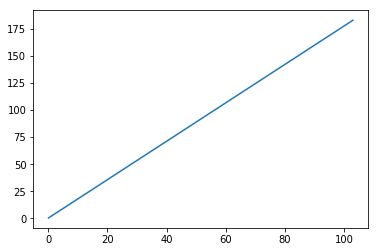

In [44]:
#Find the best stopping point
result_array = np.array(result_set)
acc_set = []
stop_set = []
for i in range(len(result_set)):
    acc_set.append(result_set[i][1])
    
plt.plot(result_array[:][1],result_array[:][0])

In [53]:
result_array.shape
acc_set = result_array[0:5][:]
acc_set.shape

(2,)